# Spotify Music Recommender using KNN Model

## Setup

In [ ]:
import os
import numpy as np
import random
import pandas as pd
import collections

from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from sklearn import set_config
import seaborn as sns
import matplotlib.cm as cm

sns.set()
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

## Data

### Ingestion

In [ ]:
!wget -q --show-progress https://github.com/RecoHut-Datasets/spotify/raw/v1/20210824_212829_artists.tsv
!wget -q --show-progress https://github.com/RecoHut-Datasets/spotify/raw/v1/20210824_212829_audios.tsv
!wget -q --show-progress https://github.com/RecoHut-Datasets/spotify/raw/v1/20210824_212829_playlists.tsv
!wget -q --show-progress https://github.com/RecoHut-Datasets/spotify/raw/v1/20210824_212829_tracks.tsv

20210824_212829_art 100%[===================>]   2.57M  --.-KB/s    in 0.06s   
20210824_212829_aud 100%[===================>]   5.80M  --.-KB/s    in 0.08s   
20210824_212829_pla 100%[===================>] 164.76K  --.-KB/s    in 0.04s   
20210824_212829_tra 100%[===================>]  15.27M  --.-KB/s    in 0.1s    


In [ ]:
!wget -q --show-progress https://github.com/RecoHut-Datasets/spotify/raw/v1/des_artist.csv
!wget -q --show-progress https://github.com/RecoHut-Datasets/spotify/raw/v1/des_audio.csv
!wget -q --show-progress https://github.com/RecoHut-Datasets/spotify/raw/v1/des_playlist.csv
!wget -q --show-progress https://github.com/RecoHut-Datasets/spotify/raw/v1/des_tracks.csv

des_artist.csv      100%[===================>]     522  --.-KB/s    in 0s      
des_audio.csv       100%[===================>]   3.35K  --.-KB/s    in 0s      
des_playlist.csv    100%[===================>]     419  --.-KB/s    in 0s      
des_tracks.csv      100%[===================>]   1.49K  --.-KB/s    in 0s      


### Loading

In [ ]:
pd_artist = pd.read_csv('20210824_212829_artists.tsv', sep='\t')
pd_audio = pd.read_csv('20210824_212829_audios.tsv', sep='\t')
pd_playlist = pd.read_csv('20210824_212829_playlists.tsv', sep='\t')
pd_track = pd.read_csv('20210824_212829_tracks.tsv', sep='\t')

### EDA

#### Description

In [ ]:
pd_track.columns.to_list()

['playlist_id',
 'track_id',
 'track_name',
 'track_duration',
 'artist_ids',
 'artist_names',
 'album_id',
 'album_name',
 'popularity']

In [ ]:
pd_track

playlist_id                track_id                         track_name  track_duration                                            artist_ids                        artist_names                album_id                         album_name  popularity
0      37i9dQZF1DXcBWIGoYBM5M  5HCyWlXZPP0y6Gqq8TgA20          STAY (with Justin Bieber)          141805  ['2tIP7SsRs7vjIcLrU85W8J', '1uNFoZAHBGtllmzznpCI3s']  ['The Kid LAROI', 'Justin Bieber']  4QLAtpLNUsHEYrcHXmMIZZ          STAY (with Justin Bieber)         100
1      37i9dQZF1DXcBWIGoYBM5M  27NovPIUIRrOZoCHxABJwK  INDUSTRY BABY (feat. Jack Harlow)          212000  ['7jVv8c5Fj3E9VhNjxT4snq', '2LIk90788K0zvyj2JJVwkJ']        ['Lil Nas X', 'Jack Harlow']  622NFw5Yk0OReMJ2XWcXUh  INDUSTRY BABY (feat. Jack Harlow)          97
2      37i9dQZF1DXcBWIGoYBM5M  3Vi5XqYrmQgOYBajMWSvCi                       Need To Know          210560                            ['5cj0lLjcoR7YOSnhnX0Po5']                        ['Doja Cat']  1nAQbHeOWTfQzbOoFrvndW                         Planet Her          92
3      37i9dQZF1DXcBWIGoYBM5M  6PQ88X9TkUIAUIZJHW2upE                         Bad Habits          231041                            ['6eUKZXaKkcviH0Ku9w2n3V']                      ['Ed Sheeran']  01NhUvviMytvV12pmJiDZH                         Bad Habits          98
4      37i9dQZF1DXcBWIGoYBM5M  3Wrjm47oTz2sjIgck11l5e                            Beggin'          211560                            ['0lAWpj5szCSwM4rUMHYmrr']                        ['Måneskin']  2qJw6w5XwQO0PQlSWPu7Tw                             Chosen          99
...                       ...                     ...                                ...             ...                                                   ...                                 ...                     ...                                ...         ...
88814  4lgseztVwmKQ8MNETPVIny  5kqIPrATaCc2LqxVWzQGbk                            7 Years          237300                            ['25u4wHJWxCA9vO0CzxAbK7']                    ['Lukas Graham']  4rFrdkSWs0dtj0rWPzOk1v                       Lukas Graham          79
88815  4lgseztVwmKQ8MNETPVIny  3FCto7hnn1shUyZL42YgfO                          Piano Man          336093                            ['6zFYqv1mOsgBRQbae3JJ9e']                      ['Billy Joel']  7r36rel1M4gyBavfcJP6Yz           The Essential Billy Joel          66
88816  4lgseztVwmKQ8MNETPVIny  3XVBdLihbNbxUwZosxcGuJ                 If I Ain't Got You          228706                            ['3DiDSECUqqY1AuBP8qtaIa']                     ['Alicia Keys']  6TqRKHLjDu5QZuC8u5Woij           The Diary Of Alicia Keys          78
88817  4lgseztVwmKQ8MNETPVIny  6QPKYGnAW9QozVz2dSWqRg                   Someone Like You          285240                            ['4dpARuHxo51G3z768sgnrY']                           ['Adele']  7n3QJc7TBOxXtlYh4Ssll8                                 21          13
88818  4lgseztVwmKQ8MNETPVIny  1VdZ0vKfR5jneCmWIUAMxK                         The A Team          258373                            ['6eUKZXaKkcviH0Ku9w2n3V']                      ['Ed Sheeran']  0W5GGnapMz0VwemQvJDqa7                                  +          75

[88819 rows x 9 columns]

In [ ]:
pd_track.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88819 entries, 0 to 88818
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   playlist_id     88819 non-null  object
 1   track_id        88819 non-null  object
 2   track_name      88812 non-null  object
 3   track_duration  88819 non-null  int64 
 4   artist_ids      88819 non-null  object
 5   artist_names    88819 non-null  object
 6   album_id        88819 non-null  object
 7   album_name      88811 non-null  object
 8   popularity      88819 non-null  int64 
dtypes: int64(2), object(7)
memory usage: 6.1+ MB


In [ ]:
pd.read_csv('des_tracks.csv')

column name  data type                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            meaning                                           example
0  playlist_id      string     The Spotify ID of the playlist                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     37i9dQZF1DXcBWIGoYBM5M                         
1  track_id         string     The Spotify ID for the track                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       5HCyWlXZPP0y6Gqq8TgA20                         
2  track_name       string     The name of the track                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              STAY (with Justin Bieber)                      
3  track_duration   int        The duration of the track in milliseconds                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [ ]:
pd_audio.columns.to_list()

['id',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'time_signature']

In [ ]:
pd_audio

id  danceability  energy  key  loudness  mode  speechiness  acousticness  instrumentalness  liveness  valence    tempo  time_signature
0      5HCyWlXZPP0y6Gqq8TgA20         0.591   0.764    1    -5.484     1       0.0483        0.0383          0.000000    0.1030    0.478  169.928               4
1      27NovPIUIRrOZoCHxABJwK         0.736   0.704    3    -7.409     0       0.0615        0.0203          0.000000    0.0501    0.894  149.995               4
2      3Vi5XqYrmQgOYBajMWSvCi         0.664   0.609    1    -6.509     1       0.0707        0.3040          0.000000    0.0926    0.194  130.041               4
3      6PQ88X9TkUIAUIZJHW2upE         0.808   0.897   11    -3.712     0       0.0348        0.0469          0.000031    0.3640    0.591  126.026               4
4      3Wrjm47oTz2sjIgck11l5e         0.714   0.800   11    -4.808     0       0.0504        0.1270          0.000000    0.3590    0.589  134.002               4
...                       ...           ...     ...  ...       ...   ...          ...           ...               ...       ...      ...      ...             ...
69866  3Zuf70897YkrVRAsrBMMSF         0.751   0.753    0    -8.198     1       0.0935        0.2270          0.000784    0.2090    0.774  106.976               4
69867  1MDoll6jK4rrk2BcFRP5i7         0.471   0.431    5    -6.129     0       0.0342        0.3290          0.000000    0.0854    0.289  157.980               4
69868  7DqTaelFf846rl1CHmyfOW         0.506   0.433    2   -14.183     0       0.0345        0.8420          0.031100    0.1120    0.641   83.222               4
69869  0ygTmpa6uSotkBkTiwcMZ4         0.493   0.590    0    -5.814     0       0.0392        0.3390          0.000000    0.1210    0.502  169.908               4
69870  3NNqqioprPCnYcVtDn3wvS         0.836   0.499    1    -9.882     0       0.0479        0.5120          0.000991    0.1110    0.109  105.012               4

[69871 rows x 13 columns]

In [ ]:
pd_audio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69871 entries, 0 to 69870
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                69871 non-null  object 
 1   danceability      69871 non-null  float64
 2   energy            69871 non-null  float64
 3   key               69871 non-null  int64  
 4   loudness          69871 non-null  float64
 5   mode              69871 non-null  int64  
 6   speechiness       69871 non-null  float64
 7   acousticness      69871 non-null  float64
 8   instrumentalness  69871 non-null  float64
 9   liveness          69871 non-null  float64
 10  valence           69871 non-null  float64
 11  tempo             69871 non-null  float64
 12  time_signature    69871 non-null  int64  
dtypes: float64(9), int64(3), object(1)
memory usage: 6.9+ MB


In [ ]:
pd.read_csv('des_audio.csv')

column name  data type                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            meaning                  example
0                 id     string                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       The Spotify ID for the track   5HCyWlXZPP0y6Gqq8TgA20
1       danceability      float                                                                                                                                                                                                                                                                        Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable                    0.591
2             energy      float                                                                                                                           Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy                    0.764
3                key        int                                                                                                                                                                                                                                                                                                                                                                                      The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on                        1
4           loudness     float                                                                                                                                                                                        The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db                    -5.484
5               mode        int                                                                                                                                                                                                                                                                                                                                                    Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0                         1
6        speechiness      float  Speechiness detects the presence of spoken words in a track. The more exclusively sp

In [ ]:
pd_playlist.columns.to_list()

['playlist_id',
 'playlist_name',
 'playlist_description',
 'playlist_num_tracks',
 'playlist_num_followers']

In [ ]:
pd_playlist

playlist_id            playlist_name                                                       playlist_description  playlist_num_tracks  playlist_num_followers
0     37i9dQZF1DXcBWIGoYBM5M         Today's Top Hits                                      Doja Cat is on top of the Hottest 50!                   50                29379379
1     37i9dQZF1DX0XUsuxWHRQd                RapCaviar               New music from Young Thug, Trippie Redd, Rod Wave and Gunna.                   50                14030878
2     37i9dQZF1DX1lVhptIYRda              Hot Country         Today's top country hits of the week, worldwide! Cover: Kane Brown                   53                 6475778
3     37i9dQZF1DX10zKzsJ2jva            ¡Viva Latino!  Today's top Latin hits are right here, on ¡Viva Latino! Cover: LIT Killah                   50                11218997
4     37i9dQZF1DX4JAvHpjipBk         New Music Friday      New music from Lorde, Young Thug, Ed Sheeran, Shawn Mendes, and more!                  100                 3788318
...                      ...                      ...                                                                        ...                  ...                     ...
1390  37i9dQZF1DX3WvGXE8FqYX             Women of Pop                                          Kick back with the queens of pop.                   70                 2185426
1391  5ji4GZJpll6twskFvKxiHx                     dw-c                                                                        NaN                   50                      14
1392  40VxbK9NqccdUDUpiUXmbp                     dw_g                                                                        NaN                   30                       8
1393  0RTz1jFo5BXGPfI8eVf8sj         Top Shower Songs                                                                        NaN                  100                      57
1394  4lgseztVwmKQ8MNETPVIny  foodora dinner playlist                                                                        NaN                   25                     151

[1395 rows x 5 columns]

In [ ]:
pd_playlist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1395 entries, 0 to 1394
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   playlist_id             1395 non-null   object
 1   playlist_name           1395 non-null   object
 2   playlist_description    1239 non-null   object
 3   playlist_num_tracks     1395 non-null   int64 
 4   playlist_num_followers  1395 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 54.6+ KB


In [ ]:
pd.read_csv('des_playlist.csv')

column name  data type                             meaning                                 example
0             playlist_id     string      The Spotify ID of the playlist                  37i9dQZF1DXcBWIGoYBM5M
1           playlist_name   'string'                The name of playlist                        Today's Top Hits
2    playlist_description   'string'         The description of playlist   Doja Cat is on top of the Hottest 50!
3     playlist_num_tracks      'int'   Number of tracks in that playlist                                      50
4  playlist_num_followers      'int'    Number of this playlist follower                                29379379

In [ ]:
pd_artist.columns.to_list()

['id', 'name', 'followers', 'popularity', 'genres']

In [ ]:
pd_artist

id                 name  followers  popularity                                                                                             genres
0      2xgAJkalFHfceCNGETOkyM                  GRX      76585          43                                                                                                 []
1      6enyYil5r9snkIazgAX5DG         Jo Ann Kelly        998          20                                                                                  ['british blues']
2      40oYPr305MsT2lsiXr9fX9    The Boomtown Rats     116274          54                ['new romantic', 'new wave', 'new wave pop', 'pub rock', 'punk', 'ska', 'synthpop']
3      3i8iJVU0mtgzbZsuF1AoJ3             sad alex      23548          52                                                                      ['alt z', 'modern indie pop']
4      5oFkj1qSlyBUmV5d6Edgtq                 Cozz     146831          57                                                                            ['underground hip hop']
...                       ...                  ...        ...         ...                                                                                                ...
34649  1tY6Z4NEPI3xHhVA8VU9Jl   Vishwa Mohan Bhatt      23094          30  ['hindustani classical', 'hindustani instrumental', 'indian classical', 'indian fusion', 'veena']
34650  7lPv78tlT005m22dYvSdNg      Lindsey Leblanc         52          32                                                                                                 []
34651  6iXZPP5qLB2dtIQ4WuNk9M  Thelonious Coltrane       4359          44                                                     ['chillhop', 'jazz boom bap', 'lo-fi jazzhop']
34652  7s9LTAKRwkBQ0CqWlbE254                Frase       2245          36                                                                                                 []
34653  5uuqghaOBgtv92jDyDveQl      Frances Forever      77788          61                                                                       ['bedroom pop', 'indie pop']

[34654 rows x 5 columns]

In [ ]:
pd_artist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34654 entries, 0 to 34653
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          34654 non-null  object
 1   name        34654 non-null  object
 2   followers   34654 non-null  int64 
 3   popularity  34654 non-null  int64 
 4   genres      34654 non-null  object
dtypes: int64(2), object(3)
memory usage: 1.3+ MB


In [ ]:
pd.read_csv('des_artist.csv')

column name  data type                                                                                                                                                                                   meaning                                   example
0          id     string                                                                                                                                                                  The Spotify ID of artist                    1uNFoZAHBGtllmzznpCI3s
1        name     string                                                                                                                                                                        Name of the artist                             Justin Bieber
2   followers        int                                                                                                                                                            Number of that artist follower                                  48927405
3  popularity        int  The popularity of the artist. The value will be between 0 and 100, with 100 being the most popular. The artist’s popularity is calculated from the popularity of all the artist’s tracks                                        98
4      genres       list                                                                                                                                         A comma seperated list of genres of that artists   ['canadian pop', 'pop', 'post-teen pop']

#### Bi-variate

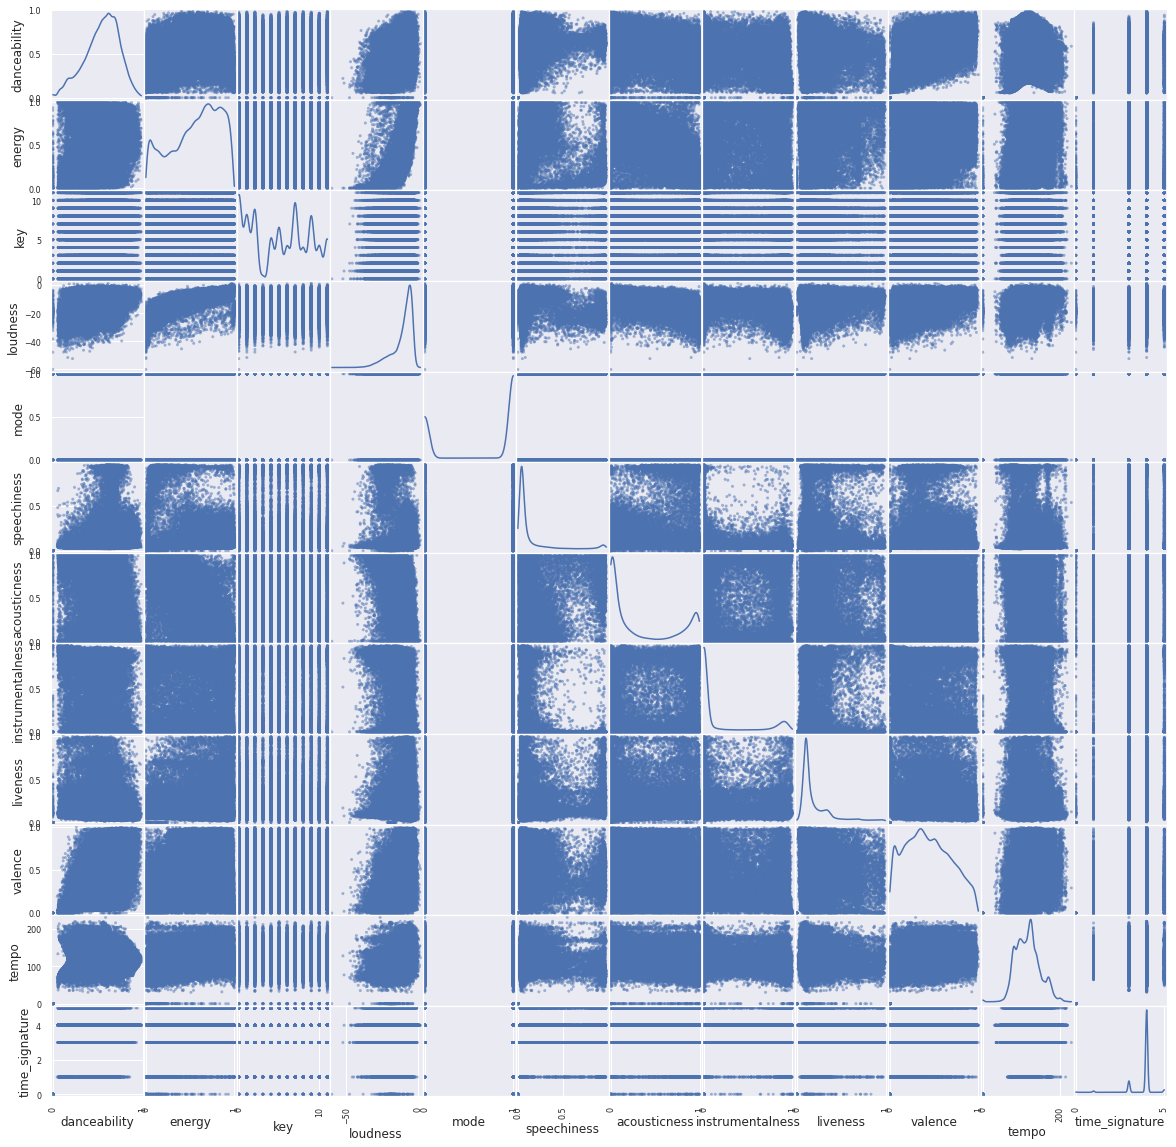

In [ ]:
pd.plotting.scatter_matrix(pd_audio, diagonal="kde", figsize=(20, 20))
plt.show()

#### Entity-Relationship Diagram

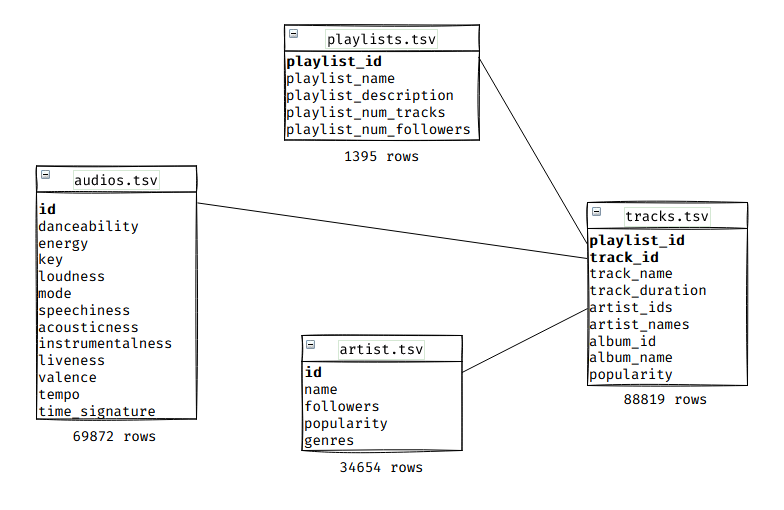

#### Merge

In [ ]:
pd_track = pd.merge(pd_track, pd_audio, left_on = 'track_id', right_on = 'id')
pd_track

playlist_id                track_id                                                                     track_name  track_duration                                            artist_ids                             artist_names                album_id                        album_name  popularity                      id  danceability  energy  key  loudness  mode  speechiness  acousticness  instrumentalness  liveness  valence    tempo  time_signature
0      37i9dQZF1DXcBWIGoYBM5M  5HCyWlXZPP0y6Gqq8TgA20                                                      STAY (with Justin Bieber)          141805  ['2tIP7SsRs7vjIcLrU85W8J', '1uNFoZAHBGtllmzznpCI3s']       ['The Kid LAROI', 'Justin Bieber']  4QLAtpLNUsHEYrcHXmMIZZ         STAY (with Justin Bieber)         100  5HCyWlXZPP0y6Gqq8TgA20         0.591   0.764    1    -5.484     1       0.0483        0.0383          0.000000    0.1030    0.478  169.928               4
1      37i9dQZF1DXcRXFNfZr7Tp  5HCyWlXZPP0y6Gqq8TgA20                                                      STAY (with Justin Bieber)          141805  ['2tIP7SsRs7vjIcLrU85W8J', '1uNFoZAHBGtllmzznpCI3s']       ['The Kid LAROI', 'Justin Bieber']  4QLAtpLNUsHEYrcHXmMIZZ         STAY (with Justin Bieber)         100  5HCyWlXZPP0y6Gqq8TgA20         0.591   0.764    1    -5.484     1       0.0483        0.0383          0.000000    0.1030    0.478  169.928               4
2      37i9dQZF1DXc2aPBXGmXrt  5HCyWlXZPP0y6Gqq8TgA20                                                      STAY (with Justin Bieber)          141805  ['2tIP7SsRs7vjIcLrU85W8J', '1uNFoZAHBGtllmzznpCI3s']       ['The Kid LAROI', 'Justin Bieber']  4QLAtpLNUsHEYrcHXmMIZZ         STAY (with Justin Bieber)         100  5HCyWlXZPP0y6Gqq8TgA20         0.591   0.764    1    -5.484     1       0.0483        0.0383          0.000000    0.1030    0.478  169.928               4
3      37i9dQZF1DWYD2pxgooM7y  5HCyWlXZPP0y6Gqq8TgA20                                                      STAY (with Justin Bieber)          141805  ['2tIP7SsRs7vjIcLrU85W8J', '1uNFoZAHBGtllmzznpCI3s']       ['The Kid LAROI', 'Justin Bieber']  4QLAtpLNUsHEYrcHXmMIZZ         STAY (with Justin Bieber)         100  5HCyWlXZPP0y6Gqq8TgA20         0.591   0.764    1    -5.484     1       0.0483        0.0383          0.000000    0.1030    0.478  169.928               4
4      37i9dQZF1DWUa8ZRTfalHk  5HCyWlXZPP0y6Gqq8TgA20                                                      STAY (with Justin Bieber)          141805  ['2tIP7SsRs7vjIcLrU85W8J', '1uNFoZAHBGtllmzznpCI3s']       ['The Kid LAROI', 'Justin Bieber']  4QLAtpLNUsHEYrcHXmMIZZ         STAY (with Justin Bieber)         100  5HCyWlXZPP0y6Gqq8TgA20         0.591   0.764    1    -5.484     1       0.0483        0.0383          0.000000    0.1030    0.478  169.928               4
...                       ...                     ...                                                                            ...             ...                                                   ...                                      ...                     ...                               ...         ...                     ...           ...     ...  ...       ...   ...          ...           ...               ...       ...      ...      ...             ...
88618  0RTz1jFo5BXGPfI8eVf8sj  3Zuf70897YkrVRAsrBMMSF  You're The One That I Want - From "Grease" Original Motion Picture Soundtrack          168466  ['4hKkEHkaqCsyxNxXEsszVH', '4BoRxUdrcgbbq1rxJvvhg9']  ['John Travolta', 'Olivia Newton-John']  0CbwlsDekgmAW03uMBjPBG           Grease (Deluxe Edition)           0  3Zuf70897YkrVRAsrBMMSF         0.751   0.753    0    -8.198     1       0.0935        0.2270          0.000784    0.2090    0.774  106.976               4
88619  4lgseztVwmKQ8MNETPVIny  1MDoll6jK4rrk2BcFRP5i7                                                                          Hello          295502                            ['4dpARuHxo51G3z768sgnrY']                                ['Adele']  5y28RdPzIRXeg

In [ ]:
pd_full = pd.merge(pd_track, pd_playlist, left_on = 'playlist_id', right_on = 'playlist_id')
pd_full = pd_full.drop('playlist_name', axis = 1)
pd_full = pd_full.drop('playlist_description', axis = 1)
pd_full = pd_full.drop('id', axis = 1)
pd_full = pd_full.drop_duplicates()
pd_full = pd_full.fillna('None')
pd_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88586 entries, 0 to 88622
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   playlist_id             88586 non-null  object 
 1   track_id                88586 non-null  object 
 2   track_name              88586 non-null  object 
 3   track_duration          88586 non-null  int64  
 4   artist_ids              88586 non-null  object 
 5   artist_names            88586 non-null  object 
 6   album_id                88586 non-null  object 
 7   album_name              88586 non-null  object 
 8   popularity              88586 non-null  int64  
 9   danceability            88586 non-null  float64
 10  energy                  88586 non-null  float64
 11  key                     88586 non-null  int64  
 12  loudness                88586 non-null  float64
 13  mode                    88586 non-null  int64  
 14  speechiness             88586 non-null

#### Correlation

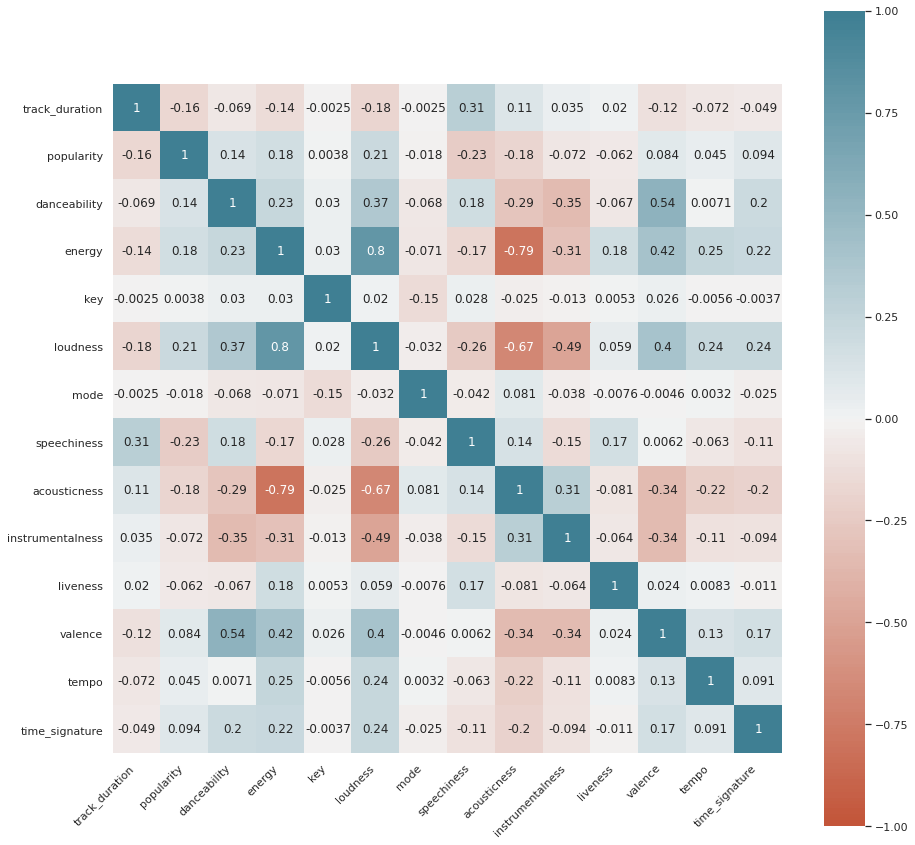

In [ ]:
names = list(pd_track.select_dtypes(np.number).columns)

data = pd_track[names]

corr = data.corr()
# plot correlation matrix
plt.figure(figsize=(15, 15))
ax = sns.heatmap(
    corr, annot=True,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

## Model

### Utils

In [ ]:
def generate_playlist(pd_track, pd_playlist, num_playlist_to_test=100, threshold=30):
    playlist_sampled = pd_playlist[pd_playlist["playlist_num_tracks"] >= threshold]
    playlist_selected = playlist_sampled["playlist_id"].sample(n=num_playlist_to_test, random_state=0)
    track_ids = {}
    for list_id in playlist_selected:
        track_ids[list_id] = list(pd_track[pd_track['playlist_id'] == list_id]['track_id'])
    return track_ids


def generate_test_playlist(track_ids, missing_rate=0.2):
    track_id_for_test = {}
    for key in track_ids:
        all_tracks = track_ids[key]
        n = len(all_tracks)
        nums_songs_to_test = int(n * (1 - missing_rate))
        track_id_for_test[key] = all_tracks[:nums_songs_to_test]
    return track_id_for_test


def r_precision(prediction, label):
    """
    Calculate r-precision: union(p,l)/size
    :rtype: r-precision score
    """
    prediction = list(set(prediction))
    label = list(set(label))
    try:
        score = len(list(set(prediction) & set(label))) / len(label)
    except Exception:
        print(f"division by zero prediction: {prediction}, label: {label}, len(label): {len(label)}")
    return score

### Data Preparation

In [ ]:
pd_artist = pd.read_csv('20210824_212829_artists.tsv', sep='\t')
pd_audio = pd.read_csv('20210824_212829_audios.tsv', sep='\t')
pd_playlist = pd.read_csv('20210824_212829_playlists.tsv', sep='\t')
pd_track = pd.read_csv('20210824_212829_tracks.tsv', sep='\t')

In [ ]:
scaler = MinMaxScaler()

playlist_test_size=100
missing_rate=0.2

In [ ]:
pd_playlist = pd_playlist.copy()
pd_track = pd_track.copy()
pd_audio = pd_audio.copy()

pd_track = pd.merge(pd_track, pd_audio, left_on='track_id', right_on='id')
pd_full = pd.merge(pd_track, pd_playlist, left_on='playlist_id', right_on='playlist_id')
pd_full = pd_full.drop('playlist_name', axis=1)
pd_full = pd_full.drop('playlist_description', axis=1)
pd_full = pd_full.drop('id', axis=1)
pd_full = pd_full.drop_duplicates()
pd_full = pd_full.fillna('None')

playlist_test = generate_playlist(pd_track, pd_playlist)
playlist_test_all_track = generate_playlist(pd_full, pd_playlist, num_playlist_to_test=playlist_test_size)
playlist_to_test = generate_test_playlist(playlist_test_all_track, missing_rate)
playlist_all_id_to_test = list(playlist_to_test.keys())

pd_full_test = pd_full.copy()
pd_full_test = pd_full_test[pd_full_test['playlist_id'].isin(playlist_all_id_to_test)]
pd_full_test = pd_full_test.reset_index(drop=True)
pd_full_test_copy = pd_full_test.copy()

columns_to_drop = ['playlist_id', 'track_id', 'track_name', 'artist_ids',
                    'artist_names', 'album_id', 'album_name',
                    'playlist_num_tracks', 'playlist_num_followers']
pd_full_test_copy = pd_full_test_copy.drop(columns_to_drop, axis=1)

sum = 0
for key in playlist_test_all_track.keys():
    sum += len(playlist_test_all_track[key])
assert sum == pd_full_test_copy.shape[0]

scaler.fit(pd_full_test_copy)
scaledpd_full_test = scaler.transform(pd_full_test_copy)

In [ ]:
class ColDropper(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.columns_to_drop = ['playlist_id', 'track_id',
                                'track_name', 'artist_ids',
                                'artist_names', 'album_id',
                                'album_name', 'playlist_num_tracks',
                                'playlist_num_followers']
        self.result_ = None

    def fit(self, x, y=None):
        return self

    def transform(self, x, y=None):
        result = x.copy()
        result = result.drop(columns=self.columns_to_drop)
        return result

### DBSCAN

#### Fitting

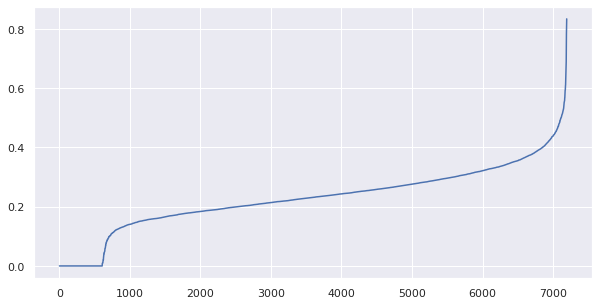

In [ ]:
plt.figure(figsize=(10, 5))
nn = NearestNeighbors(n_neighbors=5).fit(scaled_pd_full_test)
distances, idx = nn.kneighbors(scaled_pd_full_test)
distances = np.sort(distances, axis=0)

distances = distances[:, 1]
plt.plot(distances)
plt.show()

In [ ]:
dbscan = DBSCAN(eps=0.38, algorithm='ball_tree')
dbscan.fit(scaled_pd_full_test)

DBSCAN(algorithm='ball_tree', eps=0.38, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [ ]:
label = dbscan.labels_
pd_full_test_copy['cluster_label'] = label

In [ ]:
full_pipeline = Pipeline(
    [('ColDropper', ColDropper()), ('Scaler', MinMaxScaler()), ('DBSCAN', DBSCAN(eps=0.38, algorithm='ball_tree'))])
full_pipeline

Pipeline(memory=None,
         steps=[('ColDropper', ColDropper()),
                ('Scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('DBSCAN',
                 DBSCAN(algorithm='ball_tree', eps=0.38, leaf_size=30,
                        metric='euclidean', metric_params=None, min_samples=5,
                        n_jobs=None, p=None))],
         verbose=False)

In [ ]:
print(full_pipeline.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'ColDropper', 'Scaler', 'DBSCAN', 'Scaler__copy', 'Scaler__feature_range', 'DBSCAN__algorithm', 'DBSCAN__eps', 'DBSCAN__leaf_size', 'DBSCAN__metric', 'DBSCAN__metric_params', 'DBSCAN__min_samples', 'DBSCAN__n_jobs', 'DBSCAN__p'])


In [ ]:
playlist_id_to_test = playlist_all_id_to_test[0]
playlist_id_to_test

'37i9dQZF1DWX16Q183eyvd'

In [ ]:
all_name_songs = list(
    pd_full[pd_full['track_id'].isin(playlist_test_all_track[playlist_id_to_test])]['track_name'].values)
print('All song in playlist 0:', all_name_songs)

given_name_songs = list(pd_full[pd_full['track_id'].isin(playlist_to_test[playlist_id_to_test])]['track_name'].values)
print('Given in playlist 0 : ', given_name_songs)

All song in playlist 0: ["Gettin' Jiggy Wit It", "Gettin' Jiggy Wit It", 'Old Town Road', 'Girls vs. Boys', 'Dance Party in the House', 'Rise', 'Bored is a Bad Word', 'Bubble Wrap Rap', 'Dance to the Reggae Rhythm (feat. Father Goose)', 'Kool Kids', 'Wonderful People (feat. Judah Marley, Gideon Marley & Abraham Marley)', 'Girls Run Everything', 'Apple of My Eye', 'Hiphop-O-Potamus - Feat. Jabari & Baby Power', 'Can I Kick It?', 'Do My Dance', 'Take Me To Jamaica (feat. Toots Hibbert)', "If You're Happy and You Know It", 'Go Play Outside', 'Go DJ', 'Me Myself And I', 'Man Stop', 'TELL EM', 'Safari', 'Mi Gente', 'Getting Silly', 'Boomerang', 'Kids That Rock', 'Learn Your State Capitols', 'Walk Tall (feat. Paul Simon)', "I'm Healthy", 'In My Feelings', 'Three Little Birds (feat. Ziggy Marley)', 'This Old Man', 'Shake Ya Tailfeather', '1 Times Tables (TI Style)', '2 Times Tables (Biggie Style)', 'Cha Cha Slide', 'One Love / People Get Ready - Medley', 'I Like Fruit', 'Panini', 'Tennessee',

#### Recommendations

In [ ]:
def recommend_songs(given_playlist_track, pd_full_test, info_df, n_pred, eps=0.38, random_state=42, algo='ball_tree'):
    pid = list(info_df[info_df['track_id'].isin(given_playlist_track)]['playlist_id'].value_counts().index)[0]

    full_pipeline.set_params(DBSCAN__eps=eps, DBSCAN__algorithm=algo)
    full_pipeline.fit(X=pd_full_test)
    label = full_pipeline['DBSCAN'].labels_

    info_df_copy = info_df.copy()
    info_df_copy['cluster_label'] = label

    most_cluster = list(info_df_copy[info_df['playlist_id'] == pid]['cluster_label'].value_counts().index)[0]

    same_cluster_track_df = info_df[
        ~(info_df['track_id'].isin(given_playlist_track)) & (info_df_copy['cluster_label'] == most_cluster)]
    same_cluster_track_df = same_cluster_track_df.sort_values(by='popularity', ascending=False)

    result = []
    recs_names = list(np.unique(same_cluster_track_df['track_name'].values))
    preds = collections.Counter(recs_names).most_common(n_pred)
    for pred in preds:
        result.append(pred[0])

    return result

In [ ]:
recommended_songs = recommend_songs(given_playlist_track=playlist_to_test[playlist_id_to_test],
                                    pd_full_test=pd_full_test,
                                    info_df=pd_full_test,
                                    n_pred=len(playlist_test_all_track[playlist_id_to_test]) - len(
                                        playlist_to_test[playlist_id_to_test]))

print(recommended_songs)

["'Imi Au Iã 'Oe", "(Don't) Give Hate a Chance", "(I'm Gonna) Love Me Again", "(I) Think I'm in Love", "(It's Not The Express) It's The JB's Monaurail (Part 1)", '(Keep Feeling) Fascination', "(Sittin' On) the Dock of the Bay", "(That's What You Get) For Lovin' Me", '(You Make Me Feel Like) A Natural Woman', '(You Make Me Feel Like) a Natural Woman - Recorded at Spotify Studios NYC', '(Your Love Has Lifted Me) Higher and Higher']


#### Testing

In [ ]:
def test_multi(pd_playlist, pd_full, missing_rate=0.2, nums_playlists_test=100):
    r_score = []

    playlist_test_all_track = generate_playlist(pd_full, pd_playlist, num_playlist_to_test=nums_playlists_test)
    playlist_to_test = generate_test_playlist(playlist_test_all_track, missing_rate=missing_rate)

    all_playlistID_for_tests = list(playlist_to_test.keys())

    pd_full_tests = pd_full.copy()
    pd_full_tests = pd_full_tests[pd_full_tests['playlist_id'].isin(all_playlistID_for_tests)]
    pd_full_tests = pd_full_tests.reset_index(drop=True)

    pd_full_tests_copy = pd_full_tests.copy()

    recommended_songs_all_playlist = {}

    for each_playlist in all_playlistID_for_tests:
        recommended_songs = recommend_songs(playlist_to_test[each_playlist],
                                            pd_full_tests_copy,
                                            pd_full_tests,
                                            len(playlist_test_all_track[each_playlist]) - len(
                                                playlist_to_test[each_playlist]))
        recommended_songs_all_playlist[each_playlist] = recommended_songs
        all_name_songs = list(
            pd_full[pd_full['track_id'].isin(playlist_test_all_track[each_playlist])]['track_name'].values)
        given_name_songs = list(pd_full[pd_full['track_id'].isin(playlist_to_test[each_playlist])]['track_name'].values)
        songs_need_to_recommend = [song for song in all_name_songs if song not in given_name_songs]
        r_score.append(r_precision(recommended_songs, songs_need_to_recommend))
    return r_score
    
r_score = test_multi(pd_playlist, pd_full, missing_rate=0.2, nums_playlists_test=100)
missing_rates = np.arange(0.1, 1, 0.1)

for missing_rate in missing_rates:
    r_score = test_multi(pd_playlist, pd_full, missing_rate=missing_rate, nums_playlists_test=100)
    print('*' * 50)
    print('Mising rate = ', missing_rate)
    print('Average R-Precision', np.array(r_score).mean())
    print('Max R-Precision', np.array(r_score).max())
    print('*' * 50)

**************************************************
Mising rate =  0.1
Average R-Precision 0.002
Max R-Precision 0.2
**************************************************
**************************************************
Mising rate =  0.2
Average R-Precision 0.007748538011695906
Max R-Precision 0.2222222222222222
**************************************************
**************************************************
Mising rate =  0.30000000000000004
Average R-Precision 0.008915035156414466
Max R-Precision 0.23333333333333334
**************************************************
**************************************************
Mising rate =  0.4
Average R-Precision 0.011367574120718133
Max R-Precision 0.3
**************************************************
**************************************************
Mising rate =  0.5
Average R-Precision 0.0124636007341079
Max R-Precision 0.3
**************************************************
**************************************************
Mising ra

#### Visualization

In [ ]:
def visualized_cluster_result(dataframe, model_label,suptitle="TSNE2D vs. PCA2D",path_to_save="../images/fig.png"):
    sns.set();
    X = dataframe.copy()
    TSNE2 = TSNE(n_components=2,random_state=42).fit_transform(X)
    dftsne = pd.DataFrame(TSNE2)
    dftsne['cluster'] = model_label
    dftsne.columns = ['x1','x2','cluster']

    X = dataframe.copy()
    PCA2 = PCA(n_components=2,random_state=42).fit_transform(X)
    dfpca2 = pd.DataFrame(PCA2)
    dfpca2['cluster'] = model_label
    dfpca2.columns = ['x1','x2','cluster']

    fig, ax = plt.subplots(1, 2, figsize=(18,9))
    sns.scatterplot(data=dftsne,x='x1',y='x2',hue='cluster',legend="full",alpha=0.5,ax=ax[0],palette=plt.get_cmap('tab20'))
    ax[0].set_title('Visualized on TSNE 2D')
    sns.scatterplot(data=dfpca2,x='x1',y='x2',hue='cluster',legend="full",alpha=0.5,ax=ax[1],palette=plt.get_cmap('tab20'))
    ax[1].set_title('Visualized on PCA 2D')
    fig.suptitle(f'{suptitle}');

    fig.savefig(path_to_save)
    return dftsne, dfpca2

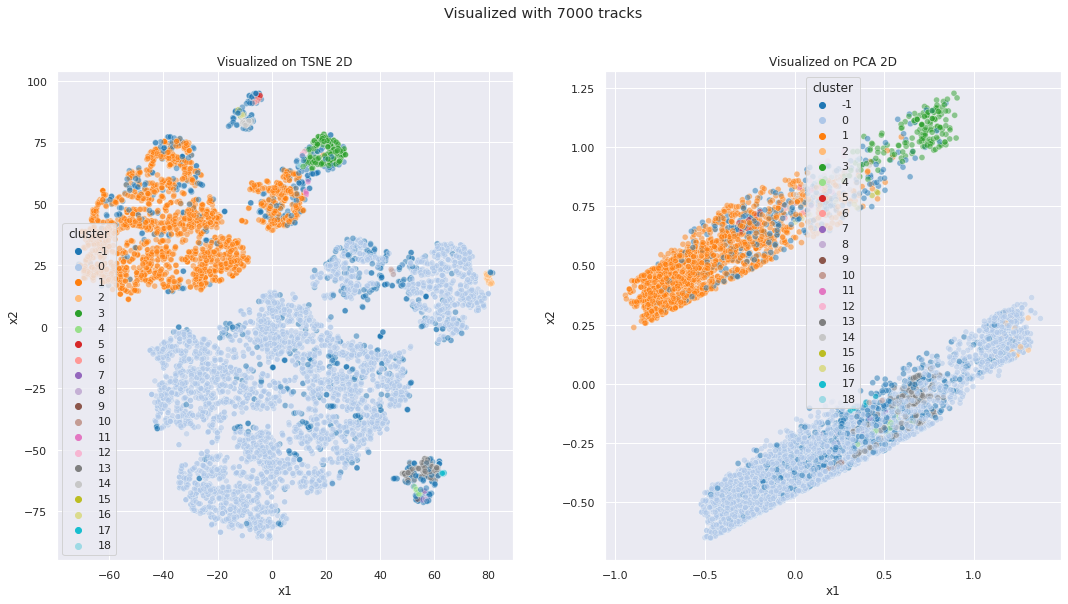

In [ ]:
db_scan_dftsne, db_scan_dfpca2 = visualized_cluster_result(scaled_pd_full_test,label,"Visualized with 7000 tracks","dbscan_7000tracks_13cluster.png")

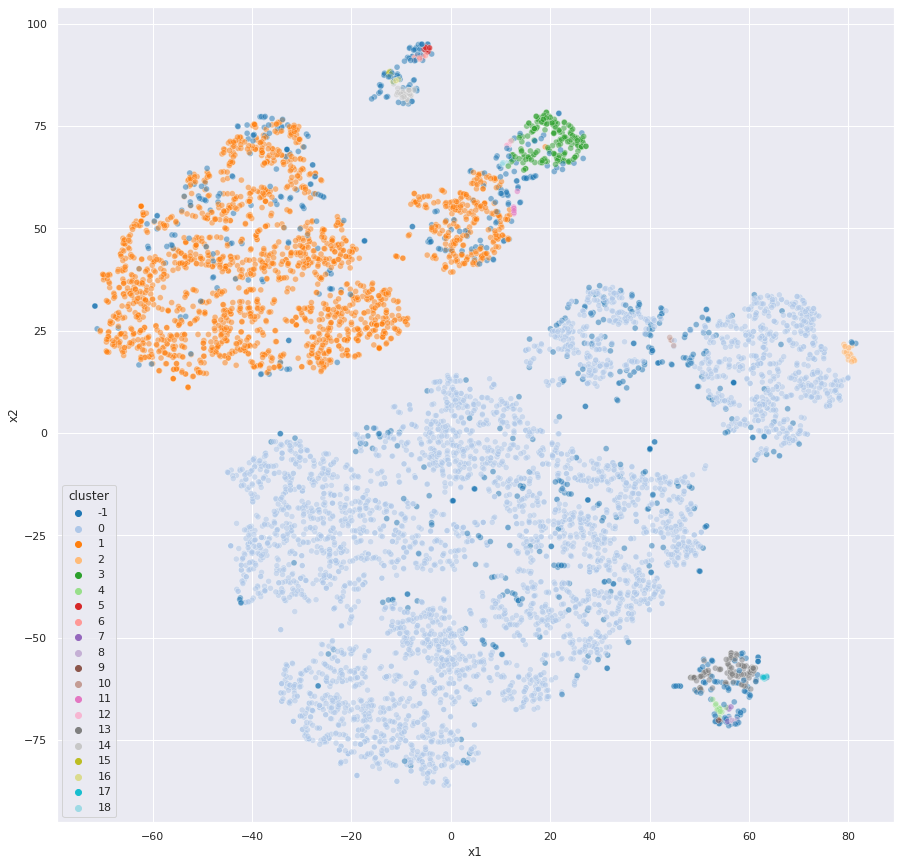

In [ ]:
sns.set();
sns.set(rc={'figure.figsize':(15,15)})
sns.scatterplot(data=db_scan_dftsne,x='x1',y='x2',hue='cluster',legend="full",alpha=0.5,palette=plt.get_cmap('tab20'))
plt.savefig("db_scan_dftsne.png")

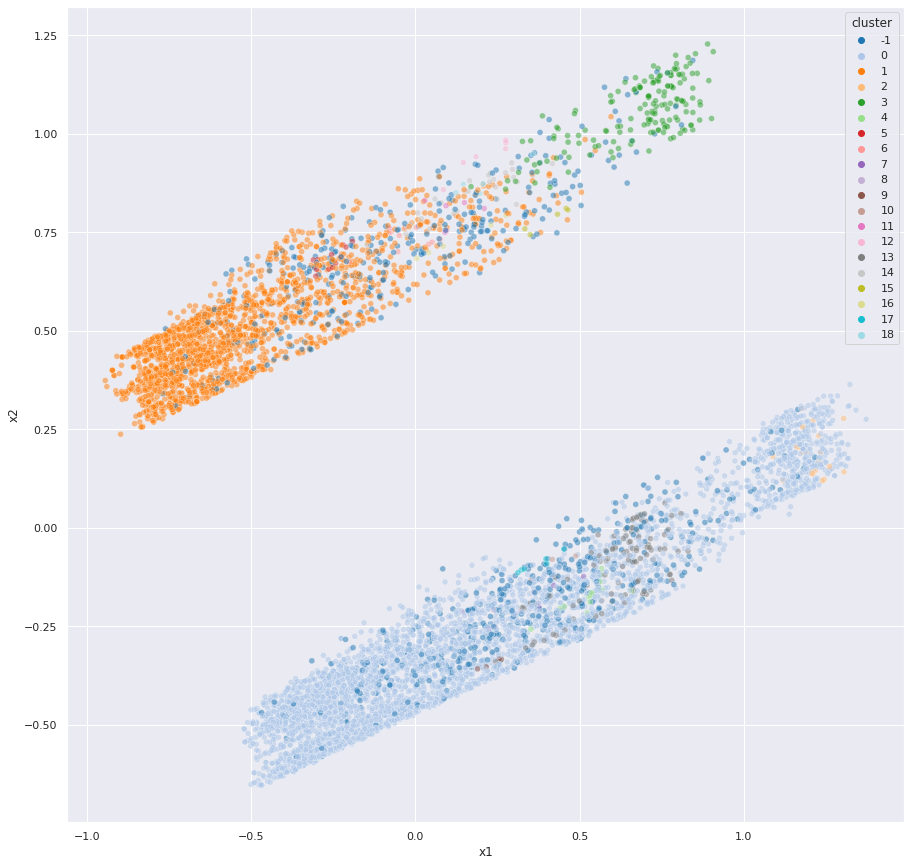

In [ ]:
sns.set();
sns.set(rc={'figure.figsize':(15,15)})
sns.color_palette("Spectral", as_cmap=True)
sns.scatterplot(data=db_scan_dfpca2,x='x1',y='x2',hue='cluster',legend="full",alpha=0.5,palette=plt.get_cmap('tab20'))
plt.savefig("db_scan_dfpca2.png")

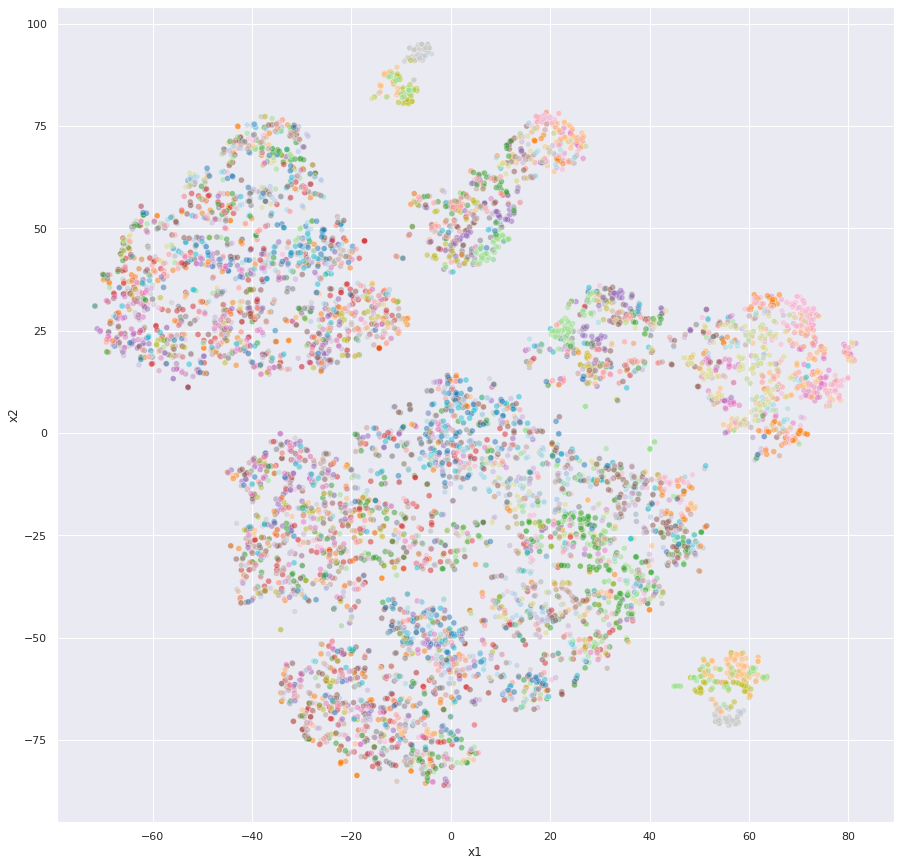

In [ ]:
sns.set();
sns.set(rc={'figure.figsize':(15,15)})
gt_dftsne = db_scan_dftsne.copy()
gt_label = LabelEncoder().fit_transform(pd_full_test["playlist_id"])
gt_dftsne['cluster'] = gt_label
sns.scatterplot(data=gt_dftsne,x='x1',y='x2',hue='cluster',legend="full",alpha=0.5, palette=plt.get_cmap('tab20'))
plt.legend([],[], frameon=False)
plt.savefig("ground_truth.png")

### KNN

#### Fitting

In [ ]:
nn = NearestNeighbors(n_neighbors=10).fit(scaled_pd_full_test)
distances, idx = nn.kneighbors(scaled_pd_full_test)
distances

array([[0.        , 0.1       , 0.1       , ..., 0.3007607 , 0.3007607 ,
        0.3007607 ],
       [0.        , 0.        , 0.        , ..., 0.34398493, 0.34398493,
        0.35158857],
       [0.        , 0.30310931, 0.32131912, ..., 0.35200195, 0.35712945,
        0.35828046],
       ...,
       [0.        , 0.24195172, 0.24263188, ..., 0.26807687, 0.26957698,
        0.27363755],
       [0.        , 0.14604166, 0.20687468, ..., 0.26598882, 0.27285152,
        0.27597394],
       [0.        , 0.16716419, 0.16948196, ..., 0.23732732, 0.24008541,
        0.24320192]])

In [ ]:
full_pipeline = Pipeline([('ColDropper', ColDropper()), ('Scaler', MinMaxScaler()), ('KNN', NearestNeighbors())])
print(full_pipeline.get_params().keys())

playlist_id_to_test = playlist_all_id_to_test[0]
playlist_id_to_test

dict_keys(['memory', 'steps', 'verbose', 'ColDropper', 'Scaler', 'KNN', 'Scaler__copy', 'Scaler__feature_range', 'KNN__algorithm', 'KNN__leaf_size', 'KNN__metric', 'KNN__metric_params', 'KNN__n_jobs', 'KNN__n_neighbors', 'KNN__p', 'KNN__radius'])


'37i9dQZF1DWX16Q183eyvd'

In [ ]:
all_name_songs = list(
    pd_full[pd_full['track_id'].isin(playlist_test_all_track[playlist_id_to_test])]['track_name'].values)
print('All song in playlist 0:', all_name_songs)

given_name_songs = list(pd_full[pd_full['track_id'].isin(playlist_to_test[playlist_id_to_test])]['track_name'].values)
print('Given in playlist 0 : ', given_name_songs)

All song in playlist 0: ["Gettin' Jiggy Wit It", "Gettin' Jiggy Wit It", 'Old Town Road', 'Girls vs. Boys', 'Dance Party in the House', 'Rise', 'Bored is a Bad Word', 'Bubble Wrap Rap', 'Dance to the Reggae Rhythm (feat. Father Goose)', 'Kool Kids', 'Wonderful People (feat. Judah Marley, Gideon Marley & Abraham Marley)', 'Girls Run Everything', 'Apple of My Eye', 'Hiphop-O-Potamus - Feat. Jabari & Baby Power', 'Can I Kick It?', 'Do My Dance', 'Take Me To Jamaica (feat. Toots Hibbert)', "If You're Happy and You Know It", 'Go Play Outside', 'Go DJ', 'Me Myself And I', 'Man Stop', 'TELL EM', 'Safari', 'Mi Gente', 'Getting Silly', 'Boomerang', 'Kids That Rock', 'Learn Your State Capitols', 'Walk Tall (feat. Paul Simon)', "I'm Healthy", 'In My Feelings', 'Three Little Birds (feat. Ziggy Marley)', 'This Old Man', 'Shake Ya Tailfeather', '1 Times Tables (TI Style)', '2 Times Tables (Biggie Style)', 'Cha Cha Slide', 'One Love / People Get Ready - Medley', 'I Like Fruit', 'Panini', 'Tennessee',

#### Recommendations

In [ ]:
def recommend_songs(given_playlist_track, pd_full_test, info_df, n_pred):
    pid = list(info_df[info_df['track_id'].isin(given_playlist_track)]['playlist_id'].value_counts().index)[0]

    full_pipeline.set_params(KNN__n_neighbors=n_pred)
    full_pipeline.fit(X=pd_full_test)

    pd_given_feature = info_df[info_df['track_id'].isin(given_playlist_track)]
    pd_given_feature = full_pipeline['ColDropper'].fit_transform(pd_given_feature)

    pd_given_feature = full_pipeline['Scaler'].fit_transform(pd_given_feature)

    distances, idx = full_pipeline['KNN'].kneighbors(pd_given_feature)
    idx = idx[:, 1:]
    distances = distances[:, 1:]
    idx = idx.flatten()

    counter = collections.Counter(idx)
    a = counter.most_common(len(counter))

    result = []
    track_duplicates = []
    i = 0
    k = 0

    while k != n_pred:
        track_id = info_df.loc[a[i][0], 'track_id']
        if (track_id not in given_playlist_track) and (track_id not in track_duplicates):
            track_duplicates.append(track_id)
            track_name = info_df.loc[a[i][0], 'track_name']
            result.append(track_name)
            i += 1
            k += 1
        else:
            i += 1

    return result

recommended_songs = recommend_songs(given_playlist_track=playlist_to_test[playlist_id_to_test],
                                    pd_full_test=pd_full_test,
                                    info_df=pd_full_test,
                                    n_pred=len(playlist_test_all_track[playlist_id_to_test]) - len(
                                        playlist_to_test[playlist_id_to_test]))

recommended_songs = recommend_songs(
    given_playlist_track=['5HCyWlXZPP0y6Gqq8TgA20', '4XvcHTUfIlWfyJTRG0aqlo', '27NovPIUIRrOZoCHxABJwK'],
    pd_full_test=pd_full_test,
    info_df=pd_full_test,
    n_pred=len(playlist_test_all_track[playlist_id_to_test]) - len(playlist_to_test[playlist_id_to_test]))

print(recommended_songs)

['She Works Hard For The Money', 'Ballroom Blitz', 'Get Lucky (feat. Pharrell Williams & Nile Rodgers)', 'Crocodile Rock', 'Do It Again', 'Listen to the Music', "That's All - Remastered 2007", 'Heart of Gold - 2009 Remaster', 'Aqualung', 'Champagne Supernova', 'With a Little Help from My Friends - Live From London']


#### Testing

In [ ]:
def test_multi(pd_playlist, pd_full, missing_rate=0.2, nums_playlists_test=100):
    r_score = []

    playlist_test_all_track = generate_playlist(pd_full, pd_playlist, num_playlist_to_test=nums_playlists_test)
    playlist_to_test = generate_test_playlist(playlist_test_all_track, missing_rate=missing_rate)

    all_playlistID_for_tests = list(playlist_to_test.keys())

    pd_full_tests = pd_full.copy()
    pd_full_tests = pd_full_tests[pd_full_tests['playlist_id'].isin(all_playlistID_for_tests)]
    pd_full_tests = pd_full_tests.reset_index(drop=True)

    pd_full_tests_copy = pd_full_tests.copy()

    recommended_songs_all_playlist = {}

    for each_playlist in all_playlistID_for_tests:
        recommended_songs = recommend_songs(playlist_to_test[each_playlist],
                                            pd_full_tests_copy,
                                            pd_full_tests,
                                            len(playlist_test_all_track[each_playlist]) - len(
                                                playlist_to_test[each_playlist]))
        recommended_songs_all_playlist[each_playlist] = recommended_songs
        all_name_songs = list(
            pd_full[pd_full['track_id'].isin(playlist_test_all_track[each_playlist])]['track_name'].values)
        given_name_songs = list(pd_full[pd_full['track_id'].isin(playlist_to_test[each_playlist])]['track_name'].values)
        songs_need_to_recommend = [song for song in all_name_songs if song not in given_name_songs]
        r_score.append(r_precision(recommended_songs, songs_need_to_recommend))
    return r_score
    
r_score = test_multi(pd_playlist, pd_full, missing_rate=0.2, nums_playlists_test=100)
missing_rates = np.arange(0.1, 1, 0.1)

for missing_rate in missing_rates:
    r_score = test_multi(pd_playlist, pd_full, missing_rate=missing_rate, nums_playlists_test=100)
    print('*' * 50)
    print('Mising rate = ', missing_rate)
    print('Average R-Precision', np.array(r_score).mean())
    print('Max R-Precision', np.array(r_score).max())
    print('*' * 50)

**************************************************
Mising rate =  0.1
Average R-Precision 0.016166666666666666
Max R-Precision 0.5
**************************************************
**************************************************
Mising rate =  0.2
Average R-Precision 0.02489596819589079
Max R-Precision 0.4
**************************************************
**************************************************
Mising rate =  0.30000000000000004
Average R-Precision 0.034785569862071083
Max R-Precision 0.5333333333333333
**************************************************
**************************************************
Mising rate =  0.4
Average R-Precision 0.03935821640327218
Max R-Precision 0.675
**************************************************
**************************************************
Mising rate =  0.5
Average R-Precision 0.04167531924248978
Max R-Precision 0.5
**************************************************
**************************************************
Mising ra

### K-Means

#### Fitting

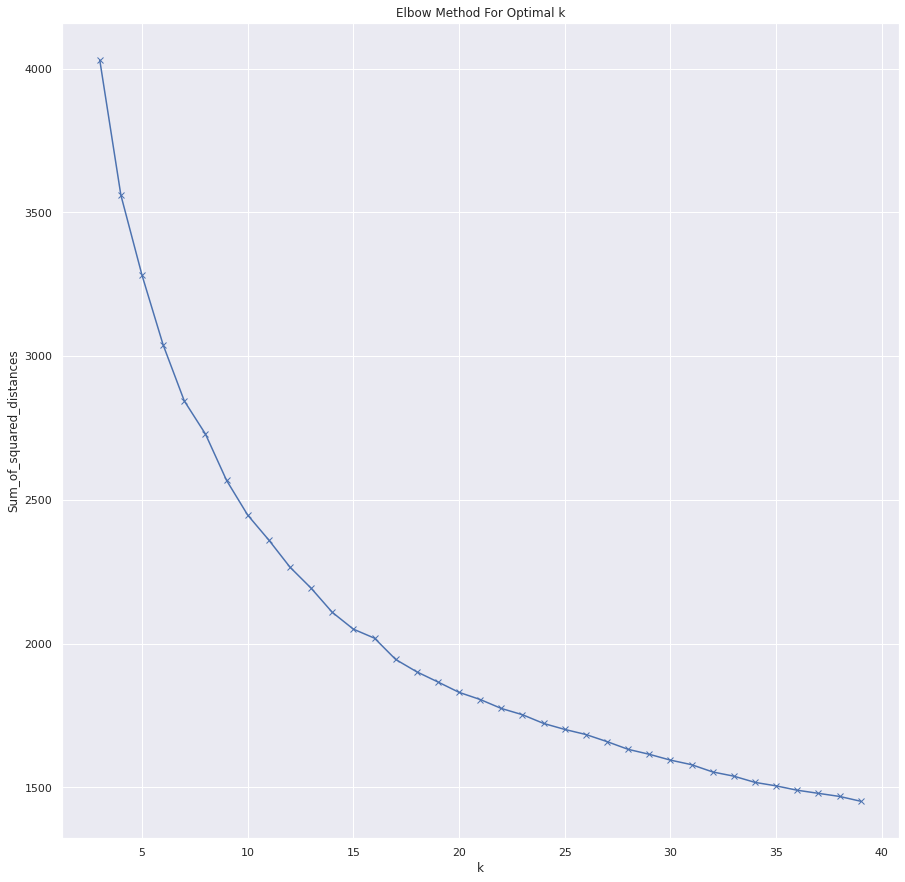

In [ ]:
Sum_of_squared_distances = []
K = range(3, 40)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans = kmeans.fit(scaled_pd_full_test)
    Sum_of_squared_distances.append(kmeans.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=13)
kmeans.fit(scaled_pd_full_test)

KMeans(n_clusters=13)
label = kmeans.labels_
pd_full_test_copy['cluster_label'] = label
pd_full_test_copy

track_duration  popularity  danceability  energy  key  loudness  mode  speechiness  acousticness  instrumentalness  liveness  valence    tempo  time_signature  cluster_label
0             141805         100         0.591   0.764    1    -5.484     1       0.0483      0.038300          0.000000    0.1030    0.478  169.928               4              3
1             231041          98         0.808   0.897   11    -3.712     0       0.0348      0.046900          0.000031    0.3640    0.591  126.026               4              6
2             178147          75         0.556   0.661    6    -5.052     0       0.2040      0.300000          0.000000    0.1010    0.668  168.560               4              7
3             208866          94         0.762   0.701    8    -3.541     1       0.0286      0.235000          0.000158    0.1230    0.742  110.968               4              5
4             203064          88         0.702   0.825    6    -3.787     0       0.0601      0.008830          0.000000    0.0674    0.915  102.977               4              7
...              ...         ...           ...     ...  ...       ...   ...          ...           ...               ...       ...      ...      ...             ...            ...
7190          196500          12         0.485   0.832    0    -4.471     0       0.1320      0.015100          0.005630    0.2590    0.280  159.885               5              7
7191          193958           1         0.486   0.190    2   -11.718     1       0.0274      0.819000          0.000014    0.3070    0.176   83.083               4             11
7192          191200           0         0.473   0.737   11    -6.636     0       0.0464      0.067800          0.000005    0.2680    0.358  120.299               4              6
7193          267341           2         0.415   0.839    9    -5.447     1       0.0521      0.000679          0.000001    0.1110    0.324  157.978               4              9
7194          202573           3         0.631   0.744    2    -5.927     1       0.0455      0.040600          0.000000    0.1270    0.450  134.870               4              0

[7195 rows x 15 columns]

In [ ]:
full_pipeline = Pipeline([('ColDropper', ColDropper()), ('Scaler', MinMaxScaler()), ('KMeans', KMeans(n_clusters=13))])
print(full_pipeline.get_params().keys())

playlist_id_to_test = playlist_all_id_to_test[0]
playlist_id_to_test

dict_keys(['memory', 'steps', 'verbose', 'ColDropper', 'Scaler', 'KMeans', 'Scaler__copy', 'Scaler__feature_range', 'KMeans__algorithm', 'KMeans__copy_x', 'KMeans__init', 'KMeans__max_iter', 'KMeans__n_clusters', 'KMeans__n_init', 'KMeans__n_jobs', 'KMeans__precompute_distances', 'KMeans__random_state', 'KMeans__tol', 'KMeans__verbose'])


'37i9dQZF1DWX16Q183eyvd'

In [ ]:
all_name_songs = list(
    pd_full[pd_full['track_id'].isin(playlist_test_all_track[playlist_id_to_test])]['track_name'].values)
print('All song in playlist 0:', all_name_songs)

given_name_songs = list(pd_full[pd_full['track_id'].isin(playlist_to_test[playlist_id_to_test])]['track_name'].values)
print('Given in playlist 0 : ', given_name_songs)

All song in playlist 0: ["Gettin' Jiggy Wit It", "Gettin' Jiggy Wit It", 'Old Town Road', 'Girls vs. Boys', 'Dance Party in the House', 'Rise', 'Bored is a Bad Word', 'Bubble Wrap Rap', 'Dance to the Reggae Rhythm (feat. Father Goose)', 'Kool Kids', 'Wonderful People (feat. Judah Marley, Gideon Marley & Abraham Marley)', 'Girls Run Everything', 'Apple of My Eye', 'Hiphop-O-Potamus - Feat. Jabari & Baby Power', 'Can I Kick It?', 'Do My Dance', 'Take Me To Jamaica (feat. Toots Hibbert)', "If You're Happy and You Know It", 'Go Play Outside', 'Go DJ', 'Me Myself And I', 'Man Stop', 'TELL EM', 'Safari', 'Mi Gente', 'Getting Silly', 'Boomerang', 'Kids That Rock', 'Learn Your State Capitols', 'Walk Tall (feat. Paul Simon)', "I'm Healthy", 'In My Feelings', 'Three Little Birds (feat. Ziggy Marley)', 'This Old Man', 'Shake Ya Tailfeather', '1 Times Tables (TI Style)', '2 Times Tables (Biggie Style)', 'Cha Cha Slide', 'One Love / People Get Ready - Medley', 'I Like Fruit', 'Panini', 'Tennessee',

#### Recommendations

In [ ]:
def recommend_songs(given_playlist_track, pd_full_test, info_df, n_pred, num_clusters=13, random_state=42):
    pid = list(info_df[info_df['track_id'].isin(given_playlist_track)]['playlist_id'].value_counts().index)[0]
    #     df_features = pd.DataFrame(df_scaled_features.copy())

    full_pipeline.set_params(KMeans__n_clusters=num_clusters, KMeans__random_state=random_state)
    full_pipeline.fit(X=pd_full_test)
    label = full_pipeline['KMeans'].labels_

    info_df_copy = info_df.copy()
    info_df_copy['cluster_label'] = label

    most_cluster = list(info_df_copy[info_df['playlist_id'] == pid]['cluster_label'].value_counts().index)[0]

    same_cluster_track_df = info_df[
        ~(info_df['track_id'].isin(given_playlist_track)) & (info_df_copy['cluster_label'] == most_cluster)]
    same_cluster_track_df = same_cluster_track_df.sort_values(by='popularity', ascending=False)

    result = []
    recs_names = list(np.unique(same_cluster_track_df['track_name'].values))
    preds = collections.Counter(recs_names).most_common(n_pred)
    for pred in preds:
        result.append(pred[0])

    return result

recommended_songs = recommend_songs(given_playlist_track=playlist_to_test[playlist_id_to_test],
                                    pd_full_test=pd_full_test,
                                    info_df=pd_full_test,
                                    n_pred=len(playlist_test_all_track[playlist_id_to_test]) - len(
                                        playlist_to_test[playlist_id_to_test]))

print(recommended_songs)

["'Merican", "(Don't Fear) The Reaper", '(I\'ve Had) The Time of My Life - From "Dirty Dancing" Soundtrack', "(We're Gonna) Rock Around The Clock - Single Version", '1 Bad Bitch', '1 Billion Views', '10 Lovers', '10 Months', '2 Minutes to Midnight - 1998 Remaster', '2019', '2055']


#### Testing

In [ ]:
def test_multi(pd_playlist, pd_full, missing_rate=0.2, nums_playlists_test=100):
    r_score = []

    playlist_test_all_track = generate_playlist(pd_full, pd_playlist, num_playlist_to_test=nums_playlists_test)
    playlist_to_test = generate_test_playlist(playlist_test_all_track, missing_rate=missing_rate)

    all_playlistID_for_tests = list(playlist_to_test.keys())

    pd_full_tests = pd_full.copy()
    pd_full_tests = pd_full_tests[pd_full_tests['playlist_id'].isin(all_playlistID_for_tests)]
    pd_full_tests = pd_full_tests.reset_index(drop=True)

    pd_full_tests_copy = pd_full_tests.copy()

    recommended_songs_all_playlist = {}

    for each_playlist in all_playlistID_for_tests:
        recommended_songs = recommend_songs(playlist_to_test[each_playlist],
                                            pd_full_tests_copy,
                                            pd_full_tests,
                                            len(playlist_test_all_track[each_playlist]) - len(
                                                playlist_to_test[each_playlist]))
        recommended_songs_all_playlist[each_playlist] = recommended_songs
        all_name_songs = list(
            pd_full[pd_full['track_id'].isin(playlist_test_all_track[each_playlist])]['track_name'].values)
        given_name_songs = list(pd_full[pd_full['track_id'].isin(playlist_to_test[each_playlist])]['track_name'].values)
        songs_need_to_recommend = [song for song in all_name_songs if song not in given_name_songs]
        r_score.append(r_precision(recommended_songs, songs_need_to_recommend))
    return r_score
    
r_score = test_multi(pd_playlist, pd_full, missing_rate=0.2, nums_playlists_test=100)
missing_rates = np.arange(0.1, 1, 0.1)

for missing_rate in missing_rates:
    r_score = test_multi(pd_playlist, pd_full, missing_rate=missing_rate, nums_playlists_test=100)
    print('*' * 50)
    print('Mising rate = ', missing_rate)
    print('Average R-Precision', np.array(r_score).mean())
    print('Max R-Precision', np.array(r_score).max())
    print('*' * 50)

**************************************************
Mising rate =  0.1
Average R-Precision 0.00475
Max R-Precision 0.25
**************************************************
**************************************************
Mising rate =  0.2
Average R-Precision 0.012327213421253671
Max R-Precision 0.2222222222222222
**************************************************
**************************************************
Mising rate =  0.30000000000000004
Average R-Precision 0.0171077311480235
Max R-Precision 0.3076923076923077
**************************************************
**************************************************
Mising rate =  0.4
Average R-Precision 0.02535929781284751
Max R-Precision 0.23529411764705882
**************************************************
**************************************************
Mising rate =  0.5
Average R-Precision 0.029953798789715887
Max R-Precision 0.19047619047619047
**************************************************
***************************

#### Visualization

In [ ]:
def visualized_cluster_result(dataframe, model_label,suptitle="TSNE2D vs. PCA2D",path_to_save="../images/fig.png"):
    sns.set();
    X = dataframe.copy()
    TSNE2 = TSNE(n_components=2,random_state=42).fit_transform(X)
    dftsne = pd.DataFrame(TSNE2)
    dftsne['cluster'] = model_label
    dftsne.columns = ['x1','x2','cluster']

    X = dataframe.copy()
    PCA2 = PCA(n_components=2,random_state=42).fit_transform(X)
    dfpca2 = pd.DataFrame(PCA2)
    dfpca2['cluster'] = model_label
    dfpca2.columns = ['x1','x2','cluster']

    fig, ax = plt.subplots(1, 2, figsize=(18,9))
    sns.scatterplot(data=dftsne,x='x1',y='x2',hue='cluster',legend="full",alpha=0.5,ax=ax[0],palette=plt.get_cmap('tab20'))
    ax[0].set_title('Visualized on TSNE 2D')
    sns.scatterplot(data=dfpca2,x='x1',y='x2',hue='cluster',legend="full",alpha=0.5,ax=ax[1],palette=plt.get_cmap('tab20'))
    ax[1].set_title('Visualized on PCA 2D')
    fig.suptitle(f'{suptitle}');

    fig.savefig(path_to_save)
    return dftsne, dfpca2

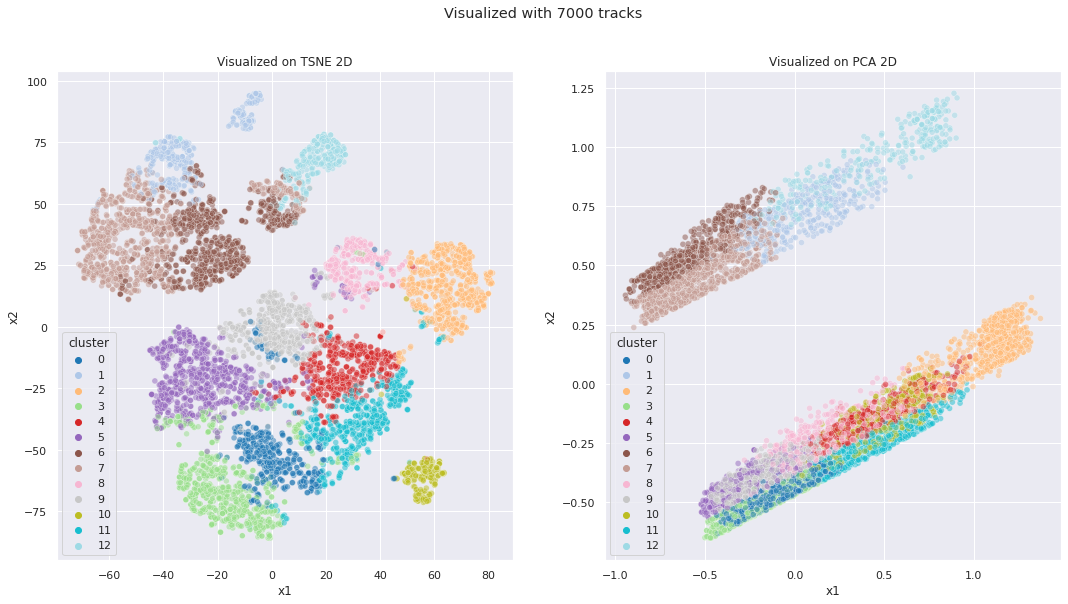

In [ ]:
kmeans_dftsne, kmeans_dfpca2 = visualized_cluster_result(scaled_pd_full_test,label,"Visualized with 7000 tracks","kmean_7000tracks_13cluster.png")

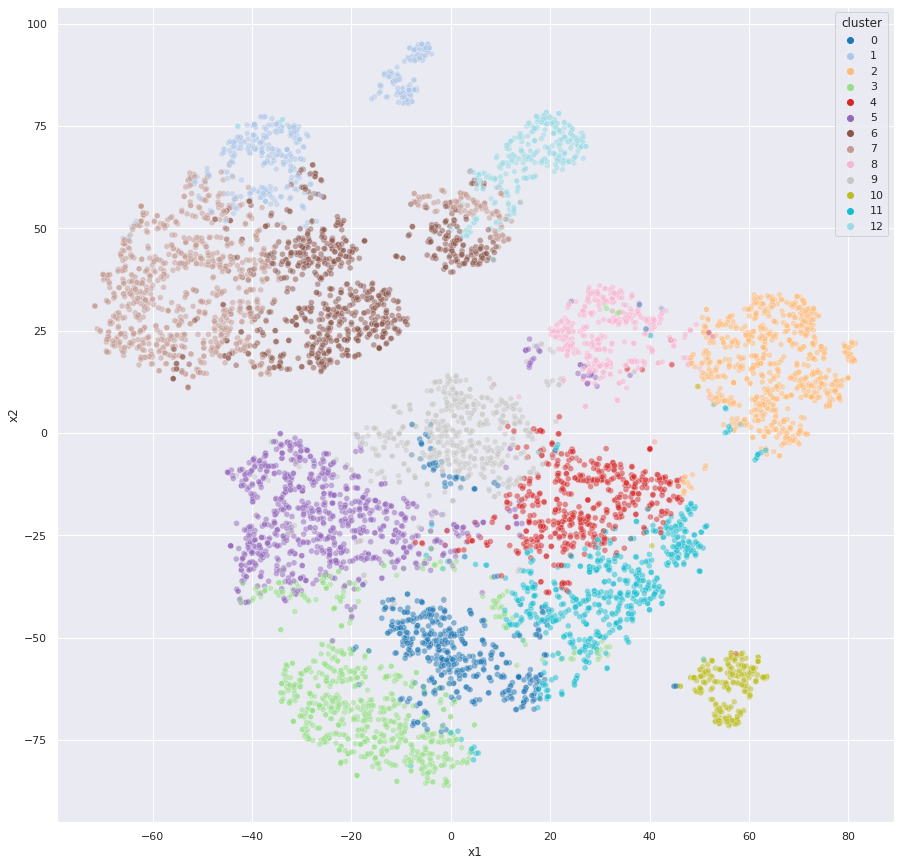

In [ ]:
sns.set();
sns.set(rc={'figure.figsize':(15,15)})
sns.scatterplot(data=kmeans_dftsne,x='x1',y='x2',hue='cluster',legend="full",alpha=0.5,palette=plt.get_cmap('tab20'))
plt.savefig("kmeans_dftsne.png")

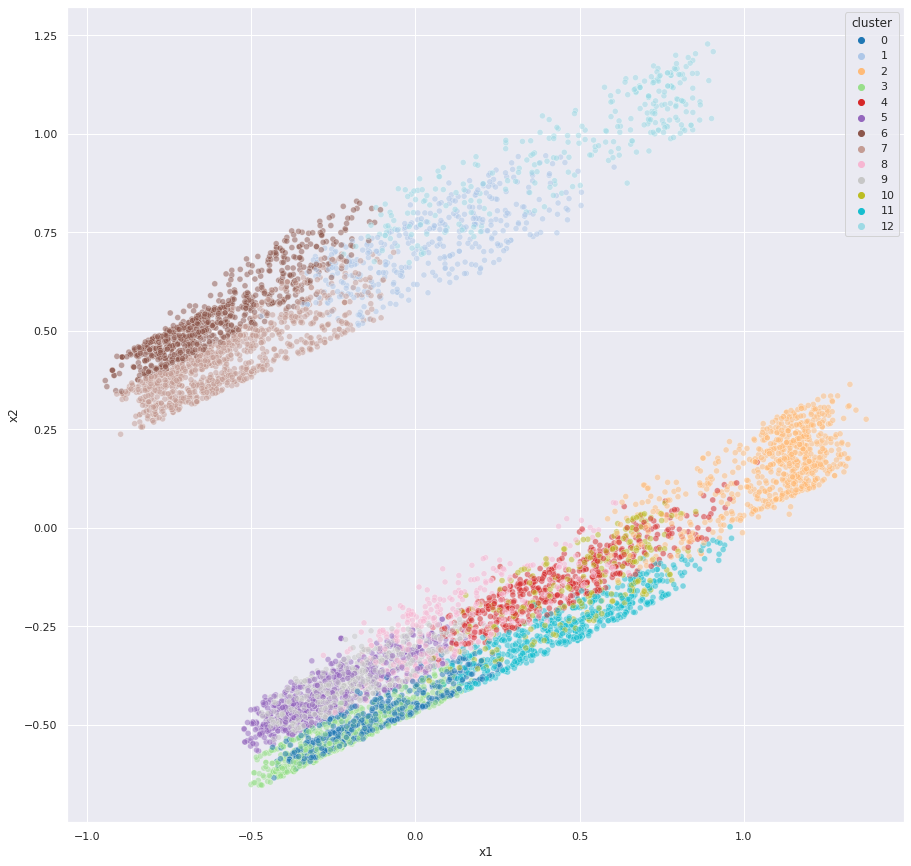

In [ ]:
sns.set();
sns.set(rc={'figure.figsize':(15,15)})
sns.scatterplot(data=kmeans_dfpca2,x='x1',y='x2',hue='cluster',legend="full",alpha=0.5,palette=plt.get_cmap('tab20'))
plt.savefig("kmeans_dfpca2.png")

---

In [ ]:
!pip install -q watermark
%reload_ext watermark
%watermark -a "Sparsh A." -m -iv -u -t -d

Author: Sparsh A.

Last updated: 2021-12-14 09:04:02

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

numpy     : 1.19.5
seaborn   : 0.11.2
matplotlib: 3.2.2
IPython   : 5.5.0
pandas    : 1.1.5



---

**END**